In [1]:
import itertools
import json
from sklearn.metrics import mean_squared_error
from data_processor import read_data
import neptune
import lightgbm as lgb

import warnings

import numpy as np
warnings.filterwarnings("ignore")

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
print('Loading data...')
x_train, y_train = read_data('../data/1000per_simulation/', 'train')
x_eval, y_eval = read_data('../data/1000per_simulation/', 'eval')

neptune.init('kowson/OLN')

Loading data...
Read dataset for train from file ../data/1000per_simulation/train.csv
Read dataset for eval from file ../data/1000per_simulation/eval.csv


Project(kowson/OLN)

In [9]:
print('Preparing LightGBM datasets...')
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_eval, y_eval, reference=lgb_train)


Preparing LightGBM datasets...


In [10]:
TAGS = ['lightgbm', 'data_v2', '10k_uniform', 'mape', 'relative']

def neptune_monitor():
    def callback(env):
        for name, loss_name, loss_value, _ in env.evaluation_result_list:
            neptune.send_metric('{}_{}'.format(name, loss_name), x=env.iteration, y=loss_value)
    return callback


In [ ]:
params_dict = {
    'boosting_type': ['dart',],
    'objective': ['regression'],
    'metric': [['l2', 'l1']],
    'num_leaves': [10, 20, 25, 30, 40, 50, 100],
    'num_rounds': [30, 50, 70, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'verbose': [0],
}

In [ ]:
ks, vs = zip(*params_dict.items())
lll = itertools.product(*vs)
for v in lll:
    print(dict(zip(ks, v)))

In [ ]:
print("Training...")
try:
    with open('lgb_params.json') as data_file:    
        used_params = json.load(data_file)
except (FileNotFoundError, json.JSONDecodeError): 
    used_params = []
keys, values = zip(*params_dict.items())
for v in itertools.product(*values):
    experiment_params = dict(zip(keys, v))
    if any(param_dict == experiment_params for param_dict in used_params):
        continue  # skip already computed
    neptune.create_experiment(
        name='LightGBM regressor', 
        params=experiment_params,
        tags=TAGS
    )
    gbm = lgb.train(
        params=experiment_params, 
        train_set=lgb_train, 
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=False,
        early_stopping_rounds=5,
        callbacks=[neptune_monitor()],
    )
    # PREDICT AND EVAL
    y_pred = gbm.predict(x_eval, num_iteration=gbm.best_iteration)
    error = mean_squared_error(y_eval, y_pred) ** 0.5
    print("RMSE of prediction is: {}".format(error))
    neptune.log_text('rmse', str(error))
    error = mean_absolute_percentage_error(y_eval, y_pred)
    print("MAPE of prediction is: {}".format(error))
    neptune.log_text('mape', str(error))
    neptune.stop()
    used_params.append(experiment_params)
    with open('lgb_params.json', 'w') as outfile:
        json.dump(used_params, outfile, sort_keys=True, indent=4)

In [11]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'l1'],
    'num_leaves': 163,
    'num_rounds': 300,
    'learning_rate': 0.09,
    'min_data_in_leaf': 58,
    'verbose': 0,
}
neptune.create_experiment(
    name='LightGBM regressor train on 10k',
    params=params,
    tags=TAGS
)
gbm = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=False,
    early_stopping_rounds=5,
    callbacks=[neptune_monitor()],
)
# PREDICT AND EVAL
y_pred = gbm.predict(x_eval, num_iteration=gbm.best_iteration)
error = mean_squared_error(y_eval, y_pred) ** 0.5
print("RMSE of prediction is: {}".format(error))
neptune.log_text('rmse', str(error))
error = mean_absolute_percentage_error(y_eval, y_pred)
print("MAPE of prediction is: {}".format(error))
neptune.log_text('mape', str(error))

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/kowson/OLN/e/OLN-3216
RMSE of prediction is: 17.569225527965305
MAPE of prediction is: 3.223870513453902


In [14]:
# PREDICT AND EVAL ON 200k
x_eval2, y_eval2 = read_data('../data/', 'dataset_relative')
y_pred2 = gbm.predict(x_eval2, num_iteration=gbm.best_iteration)
error = mean_squared_error(y_eval2, y_pred2) ** 0.5
print("RMSE of prediction is: {}".format(error))
#neptune.log_text('rmse_10k', str(error))
error = mean_absolute_percentage_error(y_eval2, y_pred2)
print("MAPE of prediction is: {}".format(error))


Read dataset for dataset_relative from file ../data/dataset_relative.csv
RMSE of prediction is: 18.291075367019626
MAPE of prediction is: 3.3292412721454965


Plotting feature importances...


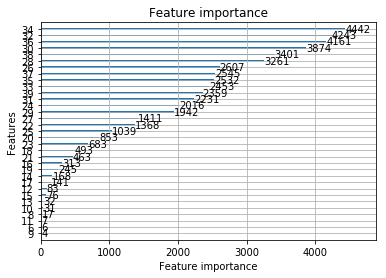

In [10]:
import matplotlib.pyplot as plt
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=45)
plt.show()

In [ ]:
neptune.stop()

In [11]:
test = gbm.feature_importance(iteration=gbm.best_iteration)

